# Burgers Equation PINN

In [2]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from utils import RAD_sampler, sample_collocation_points
from BurgerData import BurgerData

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Setup training data

In [3]:
# Initial condition
N_ic = N_bc = 100
x0 = torch.linspace(-1, 1, N_ic)
X0, U0 = torch.stack((torch.zeros_like(x0), x0), dim=-1), -torch.sin(torch.pi * x0).reshape(-1, 1)

# Boundary condition
t_bc = torch.linspace(0, 1, N_bc)
XL, XR = torch.stack((t_bc, -torch.ones_like(t_bc)), dim=-1), torch.stack((t_bc, torch.ones_like(t_bc)), dim=-1)
U_bc = torch.zeros_like(t_bc).reshape(-1, 1)

# All boundary conditions
Xbc = torch.cat((X0, XL, XR), dim=0)
Ubc = torch.cat((U0, U_bc, U_bc), dim=0)

In [4]:
# Collocation points
N_coll = 10000
Xc = sample_collocation_points(N_coll, 2, [0, -1], [1, 1], method='sobol')

In [5]:
# True solution
time_slices = [50]
data = BurgerData(time_slices=time_slices, noise_level=0.01)
Xd, Ud = data.data_points

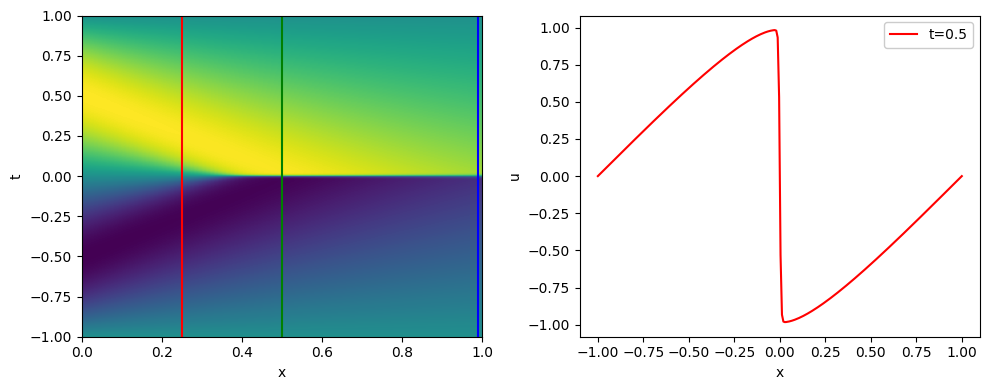

In [6]:
colors = ['r', 'g', 'b']

Ud_noiseless = data.data_points_full[1]

# Plot the initial condition, boundary conditions, and collocation points
ax, fig = plt.subplots(1, 2, figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points', markersize=1)
# plt.plot(Xd[:, 0], Xd[:, 1], 'ro', label='Data Points', markersize=1)
# plt.plot(Xbc[:, 0], Xbc[:, 1], 'bx', label='Boundary Conditions', markersize=2)
# plt.xlabel('t'); plt.ylabel('x'); plt.legend()
plt.subplot(1, 2, 1)
plt.imshow(Ud_noiseless.reshape(data.original_shape), aspect='auto', extent=[0, 1, -1, 1], cmap='viridis')
plt.plot([0.25, 0.25], [-1, 1], 'r', label='t=0.25')
plt.plot([0.5, 0.5], [-1, 1], 'g', label='t=0.5')
plt.plot([0.99, 0.99], [-1, 1], 'b', label='t=1')
plt.xlabel('x'); plt.ylabel('t')
plt.subplot(1, 2, 2)
colors = ['r', 'g', 'b']
# for i, t in enumerate(time_slices):
#     plt.scatter(data.x, Ud.reshape(-1, len(time_slices))[:, i], color=colors[i], s=1)
for i, t in enumerate(time_slices):
    plt.plot(data.x, Ud_noiseless.reshape(data.original_shape)[:, t], color=colors[i], label=f"t={data.t[t][0]}")

# plt.plot(data.x, Ud.reshape(-1, len(time_slices)), label=[f"t_noise={data.t[t][0]}" for t in time_slices])
# plt.plot(data.x, data.data_points_noiseless[1].reshape(-1, len(time_slices)), label=[f"t_true={data.t[t][0]}" for t in time_slices])
plt.xlabel('x'); plt.ylabel('u')
plt.legend().get_frame().set_alpha(1)
# plt.legend()
plt.tight_layout()
plt.savefig('gfx/burger_data.png', dpi=600)
plt.show()

### Setup Boundary Value Problem

In [7]:
class Burger(torch.nn.Module):
    def __init__(self, nu):
        super(Burger, self).__init__()
        self.nu = nu
        
        self.a = torch.nn.Parameter(torch.tensor(0.002))
        self.b = torch.nn.Parameter(torch.tensor(0.2))

        self.log = {}

    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        self.log.setdefault("nu", []).append(self.nu.item())

        return u_t - self.nu*u_xx + u*u_x

### Initialize and train PINN

In [8]:
class UPINN_burger(UPINN):
    def score(self):
        L2_rel_err = torch.sqrt( torch.mean(((self.predict(data.data_points_full[0]) - data.data_points_full[1]))**2) / torch.mean((data.data_points_full[1])**2) )
        return L2_rel_err.item()

In [9]:
# Define model architecture
hidden = [20] * 8
u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

nu = torch.nn.Parameter(torch.tensor(1.0))
N = Burger(nu)

# Instantiate the PINN
model = UPINN_burger(u, N, boundary_points=(Xbc, Ubc), data_points=(Xd, Ud), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


In [46]:
# adamw = torch.optim.AdamW(model.parameters(), lr=0.0001)
# lbfgs = torch.optim.LBFGS(model.parameters(), lr=0.1)

model.optimizer = adamw
model.train_loop(6000)

# model.optimizer = lbfgs
# for _ in range(10):
#     model.train_loop(5)
#     print(N.nu.item())
    

[Info]: Training 6000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 6000/6000 [02:25<00:00, 41.25 epoch/s, bc_loss=5.71e-06, data_loss=3.75e-05, pde_loss=4.25e-05, loss=8.57e-05]


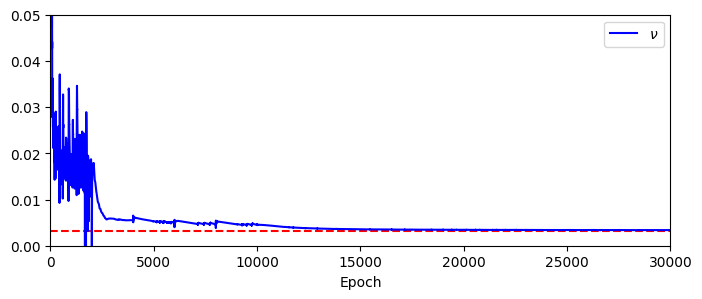

In [ ]:
plt.figure( figsize=(8, 3))
plt.plot([0, len(model.N.log['nu'])], [0.01/torch.pi]*2, 'r--')
plt.plot(model.N.log['nu'], 'b', label=r'$\nu$')
plt.ylim(0, 0.05)
plt.xlim(0, len(model.N.log['nu']))
plt.xlabel('Epoch')
plt.legend()

plt.savefig('gfx/burger_nu.pdf', format='pdf', bbox_inches='tight')


In [69]:
model.score()

0.01881183125078678

In [10]:
name = 'burgers_pinn_inverse'
model.load(name, 'models')

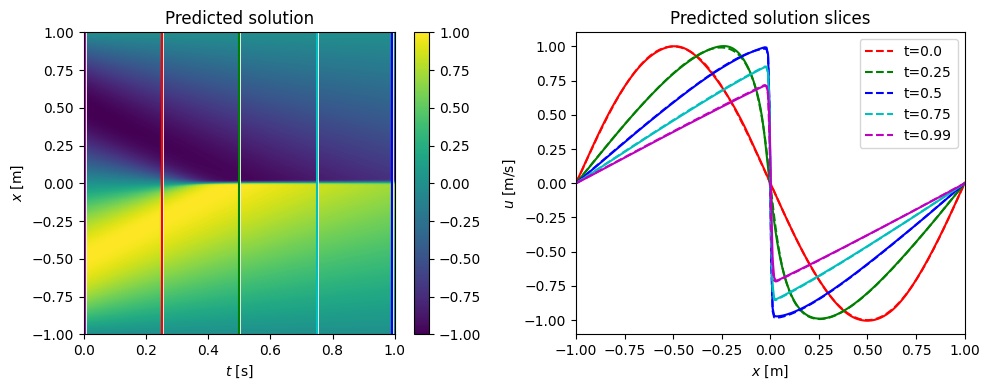

In [17]:
colors = ['m', 'r', 'g', 'c', 'b']
slices = [0.5, 25, 50, 75, 99]

T, X = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-1, 1, 256))
X_plot = torch.stack((T.flatten(), X.flatten()), dim=-1)
u_pred = model.u(X_plot).reshape(100, 256).detach().numpy()

ax, fig = plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(u_pred.T, aspect='auto', extent=[0, 1, -1, 1], origin='lower', cmap='viridis', vmin=-1, vmax=1)
for i in range(5):
    plt.plot([slices[i]/100, slices[i]/100], [-1, 1], color='w', linewidth=2)
    plt.plot([slices[i]/100, slices[i]/100], [-1, 1], color=colors[i], linestyle='-', linewidth=1.5)
plt.colorbar()
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$x$ [m]')
plt.title('Predicted solution')

colors = ['r', 'g', 'b', 'c', 'm']
slices = [0, 25, 50, 75, 99]
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(data.xsol, data.usol[:, slices[i]], '--', label=f't={slices[i]/100}', color=colors[i])
    plt.plot(data.xsol, u_pred[slices[i]], color=colors[i])

plt.legend()
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$u$ [m/s]')
plt.title('Predicted solution slices')
plt.xlim(-1, 1)

plt.tight_layout()
# Save a high quality figure
plt.savefig('gfx/PINN_prediction_burgers_inverse.pdf', format='pdf', bbox_inches='tight')